# CLUSTER INDEPENDENT ANNOTATION 

In [1]:
# import required modules
import numpy as np
import pandas as pd
import scanpy as sc
from cia import investigate, report, utils, external

## Index



1. [Introduction](#introduction)
2. [CIA input](#CIA-input)
   - [Gene signatures](#Gene-signatures)
   - [AnnData](#AnnData)
3. [Signature score](#Signature-score)
   - [Default score](#Default-score)
   - [Scaled score](#Scaled-score)
4. [Signature-based classification](#Signature-based-classification)
   - [Default classification](#Default-classification)
   - [Classification with similarity threshold](#Classification-with-similarity-threshold)
5. [Classification performance evaluation](#Classification-performance-evaluation)
6. [Tips](#Tips)
   - [Direct inspection of MSigDB signatures
](#Direct-inspection-of-MSigDB-signatures)
   - [Majority voting](#Majority-voting)
   - [Extraction of signatures from Differentially Expressed Genes](#Extraction-of-signatures-from-Differentially-Expressed-Genes)
   - [Alternative representation of cell group composition](#Alternative-representation-of-cell-group-composition)
6. [Conclusion](#Conclusion)
7. [References](#References)

In [2]:
pd.__version__

'2.2.3'

## Introduction

**Cluster Independent Annotation** (**CIA**) is a classification method designed to **assist researchers during the cell annotation step** of scRNA-seq experiments. Given gene signatures as input, this classifier **computes a signature score for each cell** and **compares the score values** to assign a label to each single cell. 

This tool offers several advantages:

-	It synthesizes the information of **an entire signature expression into a single score value**, avoiding the tedious inspection of individual marker genes from lengthy differentially expressed genes (DEGs) lists, which may not be cluster-specific individually.
-   It makes possible the exploration of new signatures derived from your research for which training data for machine learning algorithms may not yet exist.
-	It provides a classification for each cell that is **completely independent of clustering**, allowing it to be used alongside a clustering method to set a proper resolution value, thus yielding coherent and easily annotated cell groups.

-	**It's very fast**: it can classify a large dataset (hundreds of thousands of cells) in just a few seconds since **we have implemented the ability to parallelize processes**.

-	Being signature-based, this tool can deliver insights on **any kind of biologically meaningful gene list**, also enabling functional annotation. 

-	By normalizing for the gene signature length, it facilitates the **comparison of gene sets of varying lengths**, ranging **from tens to thousands of genes**.


In this tutorial we exploited CIA functions to **automatically annotate [PBMC3K](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html) scRNA-seq datasetq** at cellular level, starting from a set of gene signatures extracted from a [PBMC atlas](https://www.sciencedirect.com/science/article/pii/S0092867421005833).

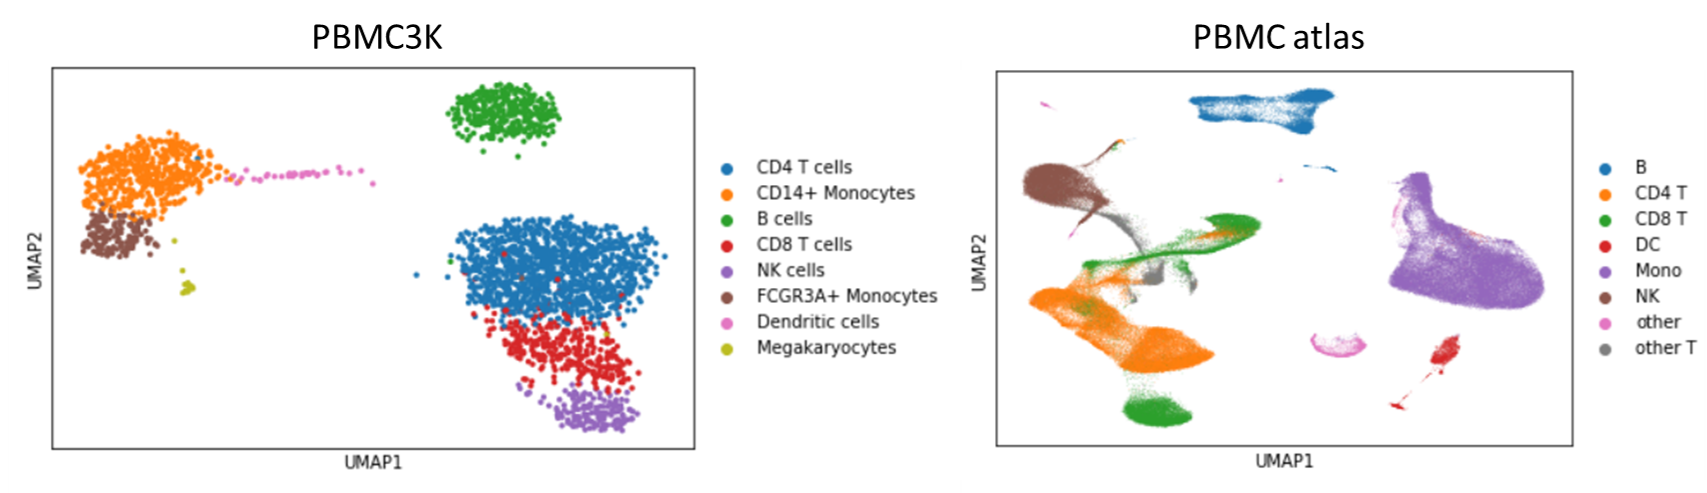

## CIA input

Our method requires as input a **dictionary containing the names of the signatures** (e.g. cell type, cell state ...) **as keys and correspondent gene names as values** and an **[AnnData](https://anndata.readthedocs.io/en/latest/)** object with a **raw expression matrix** (AnnData.raw.X) to be classified. 

### Gene signatures

In our study, we used the differentially expressed genes (DEGs) from Hao et al., 2021's [[1]](https://www.sciencedirect.com/science/article/pii/S0092867421005833) **PBMC atlas** as signature markers. The original clusters in this dataset were annotated using an integrated analysis combining RNA and protein data, ensuring the **RNA-based gene lists accurately represent specific cell types**. We focused on the broadest annotation level for clearer visualization and easier cross-dataset comparison.
**We omitted the 'other T'** label from our analysis, as it includes cell types not present in the PBMC3K dataset, making validation impossible. The **'other'** cluster, predominantly platelets, **was relabeled as 'Platelet'** for clarity.

N.B. - DEGs have been filtered to create concise and targeted gene lists: a log2 fold change greater than 1.5, a minimum average expression level of 0.25, a z-score above 5, and expression in at least 40% of the cells within each cluster.

In [3]:
# to load the gene signatures
gmt=investigate.load_signatures('data/atlas.gmt')
#load_signatures can load both dictionaries or gmt files by providing both file_paths or URLs

for i in gmt.keys():
    print(i+': '+str(len(gmt[i]))+' genes')

B: 115 genes
CD4 T: 43 genes
CD8 T: 22 genes
DC: 156 genes
Mono: 674 genes
NK: 130 genes
Platelet: 132 genes


In [4]:
# to check gene lists similarity (Jaccard Index)
utils.signatures_similarity(gmt, show='J')

,B,CD4 T,CD8 T,DC,Mono,NK,Platelet
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD4 T,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD8 T,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mono,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NK,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Platelet,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### AnnData

In order **to evaluate both the consistency** of our method **and the performances of classification**, **we used** the PMBC atlas **DEGs to automatically annotate** the [PBMC3K](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html) dataset from *Satija et al., 2015* [[2]](https://www.nature.com/articles/nbt.3192). This dataset was annotated by the authors relying on clustering and marker genes expression inspection and it is widely used as reference in the scientific community.
**We classified** this dataset **independently from the already present annotation**, whose **cell labels were used as ground truth** to evaluate our classification perfomances with different modalities.

With the intent of standardize the analysis, **we strongly suggest** to use AnnData objects preprocessed following those [**Scanpy tutorial**](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) steps:

- **standard filtering** on cells and genes.
- setting **normalized and logarithmized raw gene expression** values as .raw attribute.

In [5]:
# to load the test dataset
pbmc3k=sc.read('data/pbmc3k.h5ad')

# to normalize and logarithmize the values
sc.pp.normalize_total(pbmc3k, target_sum=1e4)
sc.pp.log1p(pbmc3k)

# to set the .raw attribute
pbmc3k.raw=pbmc3k

In [6]:
pbmc3k.uns['Cell type_colors']=['#b2df8a', '#fb9a99', '#1f78b4', '#E4D00A', '#6fadfd', '#d62728','#FF5733']

For the classification of the test dataset **we renamed and merged some clusters** in order to make easier the comparison and the visualization of results.
In particular, â€˜CD14+ Monocytes' and 'FCGR3A+ Monocytes' clusters were merged into â€˜Monoâ€™. 

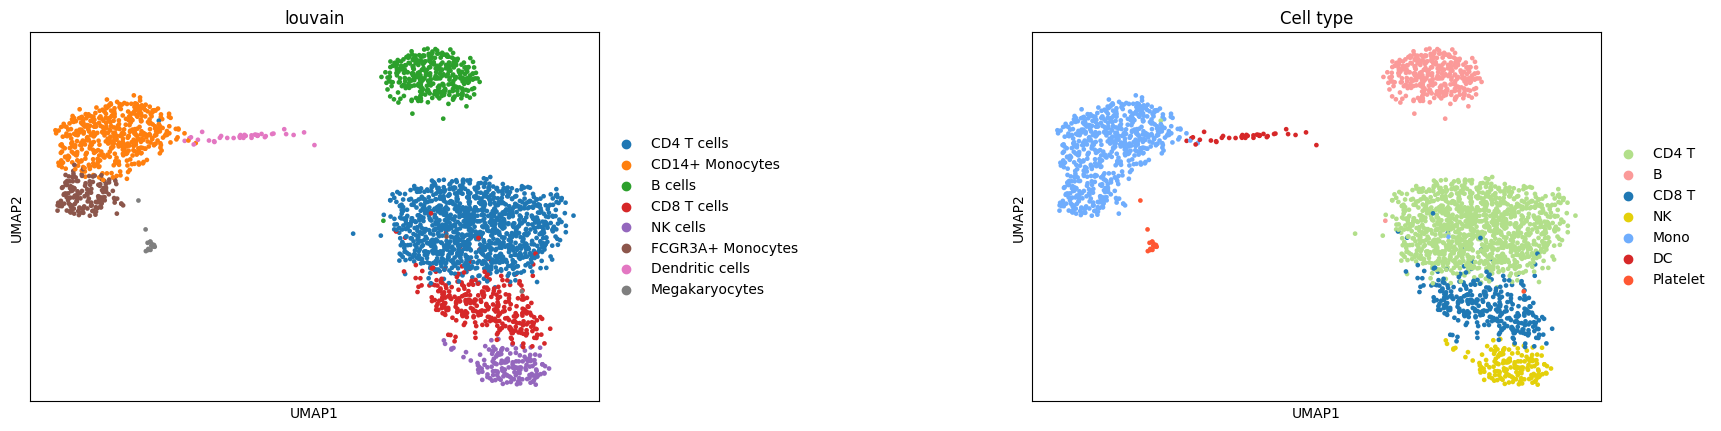

In [7]:
sc.pl.umap(pbmc3k, color=['louvain','Cell type'], wspace=0.6)

## Signature score

The `score_signature` function is **based on the "gene signature score"** calculation method presented in *Della Chiara, Gervasoni, Fakiola, Godano et al., 2021* [[3]](https://www.nature.com/articles/s41467-021-22544-y). The "gene signature score" is defined as follows:

$${GSS}(S, j) = \left( \frac{n_j}{L} \right) \times \left( \frac{\sum_{i \in S \cap G_j} X_{ij}}{\sum_{i \in G_j} X_{ij}} \right)$$

Where:

- $X$ is the gene expression matrix where $X_{ij}$ represents the expression of gene $i$ in cell $j$
- $S$ is the set of genes in the signature
- $L$ is the total number of genes in the signature $S$
- $n_j$ is the number of genes in the signature $S$ that have non-zero expression in cell $j$
- $G_j$ is the set of genes expressed (with counts > 0) in cell $j$


With this score it is possible to **condensate in a single value both the proportion of expressed signature genes and their overall expression**, enabling researchers to easily study whole signatures expression at single cell level. 

In [8]:
investigate.score_signature(data=pbmc3k, geneset=gmt['B']) 
# compute the signature scores of B cells gene signature for each cell

array([0.16288456, 2.0365728 , 0.05562652, ..., 2.26067215, 1.52375561,
       0.13641831])

### Default score

To compute the signature scores of each signature in parallel, we implemented the `score_all_signatures` function.
The function calls `load_signatures`, allowing it to support both **signature dictionaries** and canonical **gmt files** (tab separated and without header), which can be provided as either a **filepath** or a **URL**.

In [9]:
investigate.score_all_signatures(data=pbmc3k,signatures_input=gmt, score_mode='raw', return_df=True, n_cpus=32)
# "raw" is the default score mode, the one indicated as GSS in the formula.

Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 



,CD4 T,CD8 T,Platelet,B,DC,NK,Mono
0,0.212984,0.133218,0.289832,0.162885,0.101871,0.795511,3.586129
1,0.040765,0.009784,0.728088,2.036573,0.989410,0.446058,9.018179
2,0.423940,0.058274,0.555545,0.055627,0.093946,0.447281,5.277054
3,0.003293,0.003293,0.743924,0.304273,0.960809,0.397583,28.666899
4,0.015666,0.064994,0.305545,0.045849,0.312366,3.622756,1.749117
...,...,...,...,...,...,...,...
2633,0.002645,0.002645,0.676382,0.455459,2.359433,0.387395,38.973502
2634,0.072970,0.000635,0.539720,0.677553,0.449517,0.282399,6.725752
2635,0.026156,0.000000,0.150290,2.260672,0.937729,0.092876,4.705452
2636,0.001920,0.000000,0.135530,1.523756,0.608006,0.238040,3.352826


**Signature scores are stored by default in AnnData.obs**, adding a column for each signature, named accordingly to the signature name. With return_df=True a dataframe is also returned.

### Scaled score

The scaled score is the **GSS divided by the maximum score value**, an operation that rescales the values from 0 to 1. This allows scaled scores of **different signatures**, even with **varying lengths**, to be **directly compared**. To compute the 'scaled' score, score_mode must be set to 'scaled'.

In [10]:
investigate.score_all_signatures(data=pbmc3k, signatures_input=gmt, score_mode='scaled', n_cpus=32)

Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 



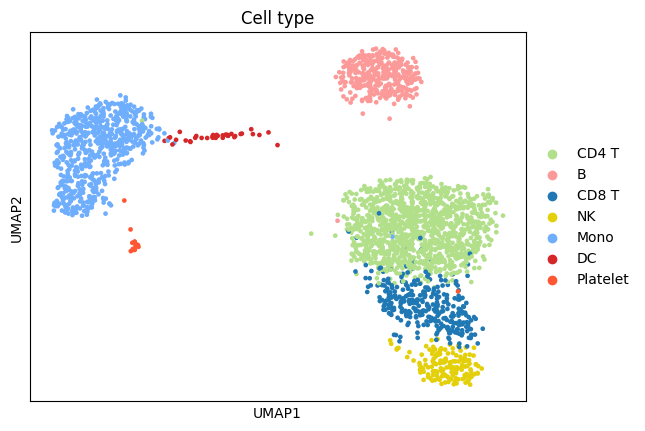

In [11]:
sc.pl.umap(pbmc3k, color='Cell type')

By inspecting the score values, for all the signatures, **the highest values are found in the proper cluster**, indicating the sensitivity of the signatures and the capability of the signature score to represent the expression of the whole gene lists.

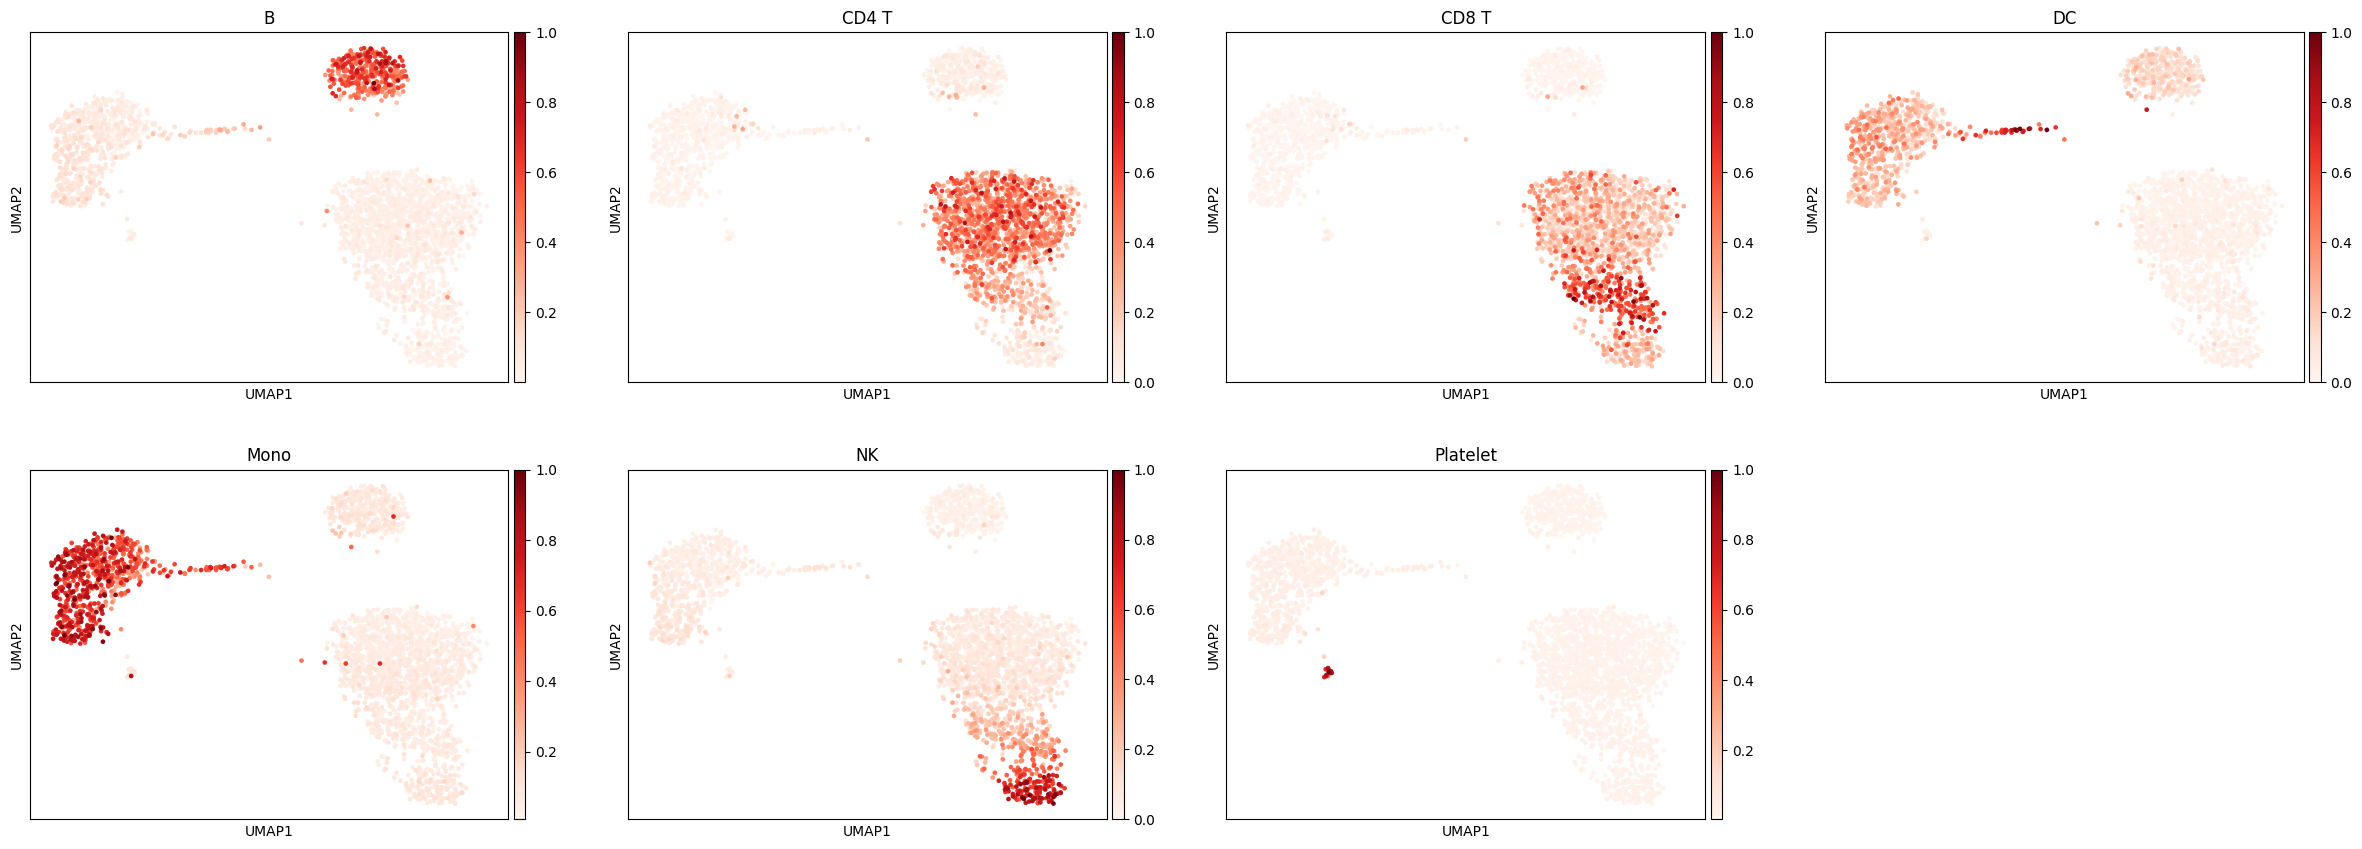

In [12]:
sc.pl.umap(pbmc3k, color=gmt.keys(), color_map='Reds')

To better viusualize those distributions, we exploited `grouped_distributions`. By selecting AnnData.obs columns containing **signature scores**, this function plots **a heatmap showing the medians of their values in cell groups** and it prints **a statistical report**.
**For each cell group**, a two-sided **Wilcoxon test** is perfomed to evaluate if the distribution with the highest median is different from the others. **For each signature**, a two-sided **Mann-Whitney U test** is performed to evaluate if the distribution in the cell group having the highest median is different from the other groups distributions.

In [13]:
grouped_df=pbmc3k.obs[['CD4 T', 'B', 'CD8 T', 'NK', 'Mono', 'DC', 'Platelet']].median()

Performing Wilcoxon test on each cell group ...
WARNING in cell group DC: DC values are not significantly different from Mono values.

Performing Mann-Whitney U test on each selected AnnData.obs column ...
For each distribution, there is only a cell group in which values are higher with respect to all the other groups  (p<0.01)


<Axes: ylabel='Cell type'>

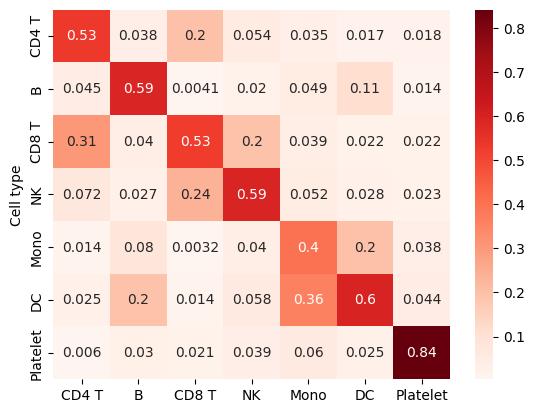

In [14]:
report.grouped_distributions(pbmc3k, ref_obs='Cell type', columns_obs=['CD4 T', 'B', 'CD8 T', 'NK', 'Mono', 'DC', 'Platelet'],
                             scale_medians='column-wise', cmap='Reds')

The statistical tests confirmed that the **visible differences in signature score distributions are significant**, indicating that scaled signature scores are consistent with authors annotation. 
With the evidence of the goodness of the signatures, we proceeded with the classification of PBMC3K.

## Signature-based classification 

To classify the PBMC3K dataset we used `CIA_classify`, which directly computes and compares scaled scores of each signature in each single cell of the dataset 

### Default classification

In [15]:
%%time
investigate.CIA_classify(data=pbmc3k, signatures_input=gmt, similarity_threshold=0, 
                                           label_column='CIA prediction default', n_cpus=32)

Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:01, End time: 16:55:02, Results stored in AnnData.obs["CIA prediction default"]
CPU times: user 462 ms, sys: 12.1 ms, total: 474 ms
Wall time: 340 ms


Classification is performed by **assigning to each cell the label of the signature that has the maximum scaled score value**. Because it is based on matrix and vector operations, and given the possibility to parallelize the computation, this process is **very fast**.

In [16]:
pbmc3k.uns['CIA prediction default_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733']

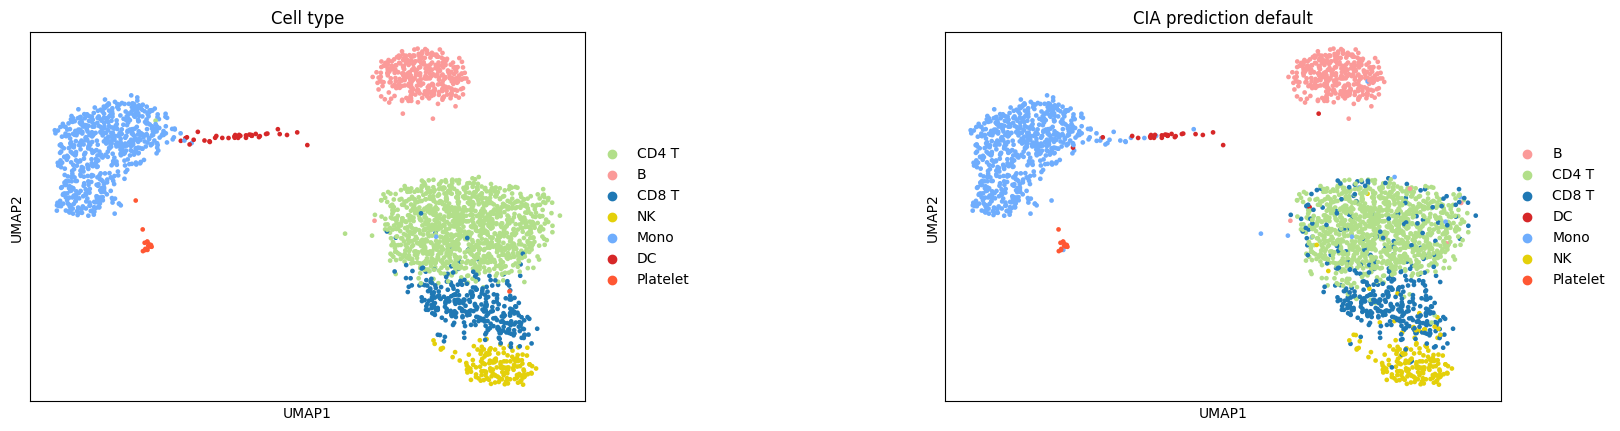

In [17]:
sc.pl.umap(pbmc3k, color=['Cell type','CIA prediction default'], wspace=0.5)

<Axes: xlabel='CIA prediction default', ylabel='Cell type'>

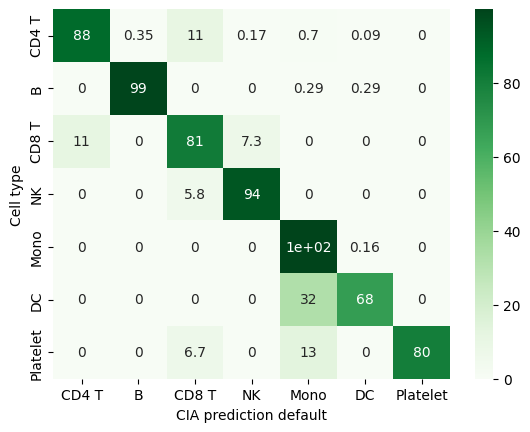

In [18]:
report.group_composition(pbmc3k, classification_obs='CIA prediction default', ref_obs='Cell type',
                  columns_order=['CD4 T', 'B', 'CD8 T', 'NK', 'Mono', 'DC', 'Platelet'], cmap='Greens')

The confusion matrix reveals that the classification method is highly effective, with most cells being correctly labeled according to their true cell types. The errors that did occur are relatively few and can be summarized as follows:

- **CD4 T cells:** Predominantly classified correctly, with a small number misclassified as CD8 T cells.
- **CD8 T cells:** Mostly identified accurately, but with some confusion with NK cells noted.
- **Dendritic cells:** Generally well-classified, although there is a tendency for some cells to be mislabeled as monocytes.

### Classification with similarity threshold

The similarity threshold is a critical parameter in the classification process, utilized within the `CIA_classify` function. It sets **the minimum required difference between the highest and second-highest signature scores** for a cell to be confidently classified into a specific category. This threshold **prevents ambiguous classifications** and ensures that cells are distinctly assigned to the most appropriate categories based on their signature expression levels.

Cells whose signature scores do not meet this threshold are labeled as **'Unassignned'**. This label indicates that these cells do not exhibit a strong correlation with any of the predefined signatures, thus avoiding misclassification.

Here we test 3 tresholds: 5%, 10% and 15%.

In [19]:
for t in [0.05, 0.1, 0.15]:
    investigate.CIA_classify(data=pbmc3k, signatures_input=gmt, similarity_threshold=t, label_column='CIA prediction t='+str(t), 
                             n_cpus=32)

Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:02, End time: 16:55:03, Results stored in AnnData.obs["CIA prediction t=0.05"]
Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:03, End time: 16:55:03, Results stored in AnnData.obs["CIA prediction t=0.1"]
Checking if genes are in AnnData.var_names...

B: 101/115
CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:03, End time: 16:55:03, Results stored in AnnData.obs["CIA prediction t=0.15"]


In [20]:
pbmc3k.uns['CIA prediction t=0.05_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733','#808080']
pbmc3k.uns['CIA prediction t=0.1_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733','#808080']
pbmc3k.uns['CIA prediction t=0.15_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733','#808080']

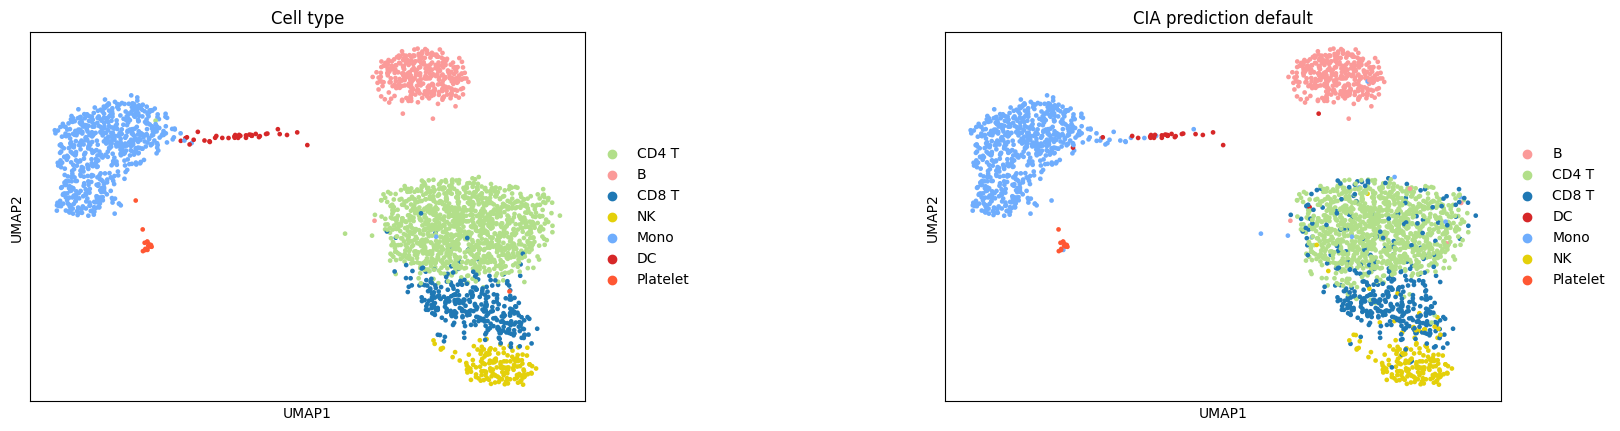

In [21]:
sc.pl.umap(pbmc3k, color=['Cell type','CIA prediction default'], wspace=0.5)

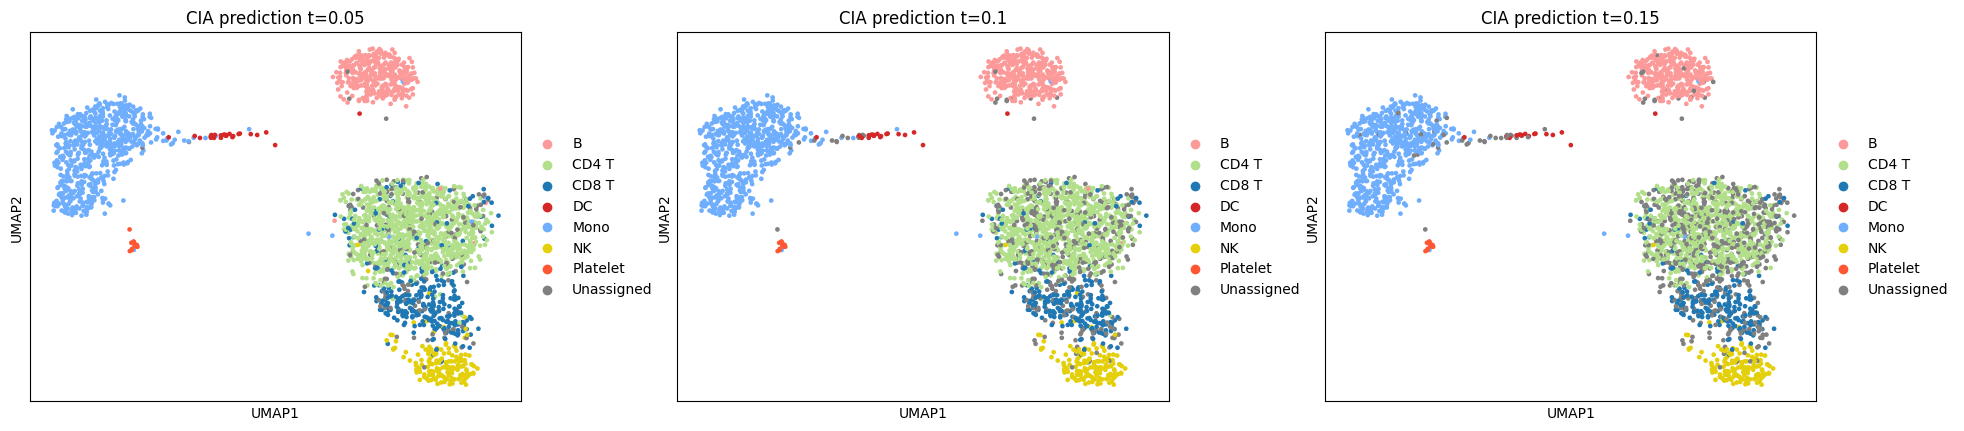

In [22]:
sc.pl.umap(pbmc3k, color=['CIA prediction t=0.05', 'CIA prediction t=0.1', 'CIA prediction t=0.15'], wspace=0.2)

Raising the similarity threshold in the classification algorithm indeed leads to a greater number of cells being labeled as **"Unassigned"**. This change typically affects **cells that previously might have been incorrectly classified**, particularly those within groups that exhibit closely related signature profiles. As the similarity threshold increases, the classifier becomes more conservative, requiring a higher degree of confidence before assigning a label. Consequently, **cells that do not distinctly match a particular signature according to the stricter criteria are more likely to remain unclassified**.

To further show the importance of this threshold we removed a signature from the dictionary in order to simulate the situation in which a cell type of the dataset is not represented by the signatures.

In [23]:
del gmt['B'] # B cells signature as been removed

In [24]:
for t in [0, 0.1]:
    investigate.CIA_classify(data=pbmc3k, signatures_input=gmt, similarity_threshold=t, 
                                           label_column='CIA no B t='+str(t), n_cpus=32)

Checking if genes are in AnnData.var_names...

CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:04, End time: 16:55:04, Results stored in AnnData.obs["CIA no B t=0"]
Checking if genes are in AnnData.var_names...

CD4 T: 40/43
CD8 T: 20/22
DC: 151/156
Mono: 649/674
NK: 126/130
Platelet: 123/132 

Classification complete! Start time: 16:55:04, End time: 16:55:05, Results stored in AnnData.obs["CIA no B t=0.1"]


In [25]:
pbmc3k.uns['CIA no B t=0_colors']=['#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733']
pbmc3k.uns['CIA no B t=0.1_colors']=[ '#b2df8a', '#1f78b4', '#d62728', '#6fadfd', '#E4D00A','#FF5733','#808080']

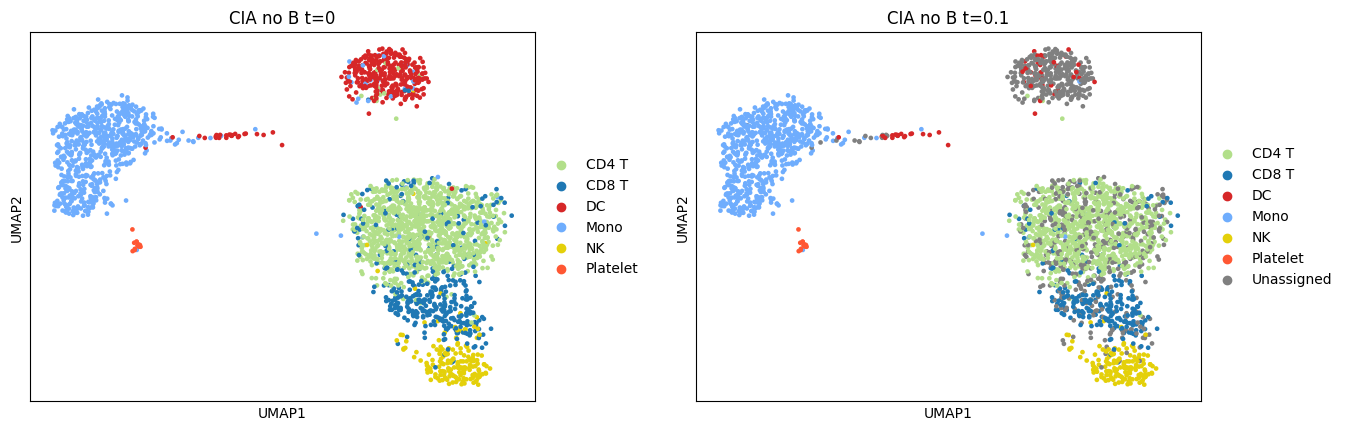

In [26]:
sc.pl.umap(pbmc3k, color=['CIA no B t=0', 'CIA no B t=0.1'], wspace=0.2)

Indeed, applying a similarity threshold has proven to be a **crucial step for enhancing the specificity and reliability of the classification results**. It has effectively reduced the mislabeling of B cells as Dendritic Cells (DC), demonstrating its value in refining the accuracy of cell type predictions. Moreover, the threshold's role in identifying 'Unassigned' cells **helps flag potential new or unexpected cell types**, such as contaminants or previously unidentified cell populations, within the sample. This feature is especially beneficial for exploratory analyses where novel discoveries are a possibility.

## Classification performance evaluation

To evaluate classification performances both per ground truth cluster and overall we exploited respectively `grouped_classification_metrics` and `compute_classification_metrics` functions.  

In both functions **cell labels assigned by CIA and the annotation already present in test datasets are compared** in order to count true positive (TP), true negative (TN), false positive (FP) and false negative (FN) cells for each cluster. 
Only for the overall calculation the per-cluster counts are summed to obtain the total TN, TP, FN and FP.

Then, again for both functions, the following metrics are calculated:
- **Sensitivity** (SE)= TP/(TP+FN)
- **Specificity** (SP)= TN/(TN+FP)
- **Precision** (PR)= TP/(TP+FP)
- **Accuracy** (ACC)= (TN+TP)/(TN+TP+FN+FP)
- **F1-score** (F1)= 2*TP/(2*TP+FN+FP)


N.B.: the column of the classification of interest and the one with ground truth labels must have the same categories to be compared.

Here, for clarity, we show only the **per-cluster classification** metrics of a single classification.

In [27]:
report.grouped_classification_metrics(pbmc3k, classification_obs='CIA prediction default',ref_obs='Cell type')

,SE,SP,PR,ACC,F1
CD4 T,0.881119,0.975904,0.965517,0.934799,0.921389
B,0.994152,0.998258,0.988372,0.997726,0.991254
CD8 T,0.813291,0.943583,0.662371,0.927976,0.730114
NK,0.941558,0.989936,0.852941,0.987111,0.895062
Mono,0.998413,0.988546,0.964724,0.990902,0.981279
DC,0.675676,0.998847,0.892857,0.994314,0.769231
Platelet,0.800000,1.000000,1.000000,0.998863,0.888889


And here are reported the **overall perfomances of each classification modality**:

In [28]:
report.compute_classification_metrics(pbmc3k, 
                                      classification_obs=['CIA prediction default', 'CIA prediction t=0.05', 
                                                          'CIA prediction t=0.1', 'CIA prediction t=0.15',
                                                          'CIA no B t=0', 'CIA no B t=0.1'], ref_obs='Cell type')

,SE,SP,PR,ACC,F1
CIA prediction default,0.915845,0.985974,0.915845,0.975956,0.915845
CIA prediction t=0.05,0.871114,0.990081,0.936049,0.973086,0.902415
CIA prediction t=0.1,0.803260,0.993240,0.951932,0.966100,0.871299
CIA prediction t=0.15,0.736164,0.994946,0.960435,0.957977,0.833476
CIA no B t=0,0.787339,0.964556,0.787339,0.939240,0.787339
CIA no B t=0.1,0.678923,0.991218,0.927979,0.946605,0.784151


As the similarity threshold is raised, **overall classification performance may decrease due to an increase in the number of 'Unassigned' cells**, which are counted as misclassified. However, **by setting the unassigned_label, we can exclude 'Unassigned' cells from performance metrics calculations**, thereby refining our analysis. Consequently, a new column indicating the percentage of unlabeled cells will be included in the output, providing additional insight into the classification process.

In [29]:
report.compute_classification_metrics(pbmc3k, classification_obs=['CIA prediction default', 'CIA prediction t=0.05',
                                                          'CIA prediction t=0.1', 'CIA prediction t=0.15',
                                                          'CIA no B t=0', 'CIA no B t=0.1'],
                              unassigned_label='Unassigned', ref_obs='Cell type')

,SE,SP,PR,ACC,F1,%UN
CIA prediction default,0.915845,0.985974,0.915845,0.975956,0.915845,0.00
CIA prediction t=0.05,0.936049,0.989341,0.936049,0.981728,0.936049,6.94
CIA prediction t=0.1,0.951932,0.991989,0.951932,0.986266,0.951932,15.62
CIA prediction t=0.15,0.960435,0.993406,0.960435,0.988696,0.960435,23.35
CIA no B t=0,0.787339,0.964556,0.787339,0.939240,0.787339,0.00
CIA no B t=0.1,0.927979,0.987997,0.927979,0.979423,0.927979,26.84


## Tips

### Direct inspection of MSigDB signatures

With the `score_signature` and `score_all_signatures` functions, you can compute and inspect signatures from the [MSigDB](https://www.gsea-msigdb.org/gsea/msigdb/) by simply providing the corresponding URL.

<div class="alert alert-block alert-warning"> 
<b>NOTE</b>: <br>
In the Python package, the URL works only for those pointing to the GMT file of the gene set.
For the MSigDB collections, refer to the procedure described above and download it to your working environment as shown earlier.
Improvements for this feature are planned for a future release.
</div>

In [32]:
investigate.score_signature(data=pbmc3k, 
                            geneset='https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=GOBP_PHAGOCYTOSIS&fileType=gmt')

array([0.19905782, 0.76144388, 0.50933343, ..., 0.16824221, 0.23230599,
       0.17988258])

Checking if genes are in AnnData.var_names...

GOBP_PHAGOCYTOSIS: 177/241 



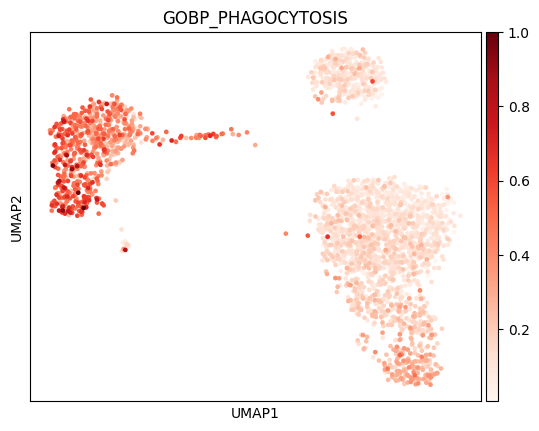

In [31]:
investigate.score_all_signatures(data=pbmc3k, signatures_input='https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=GOBP_PHAGOCYTOSIS&fileType=gmt',
                            score_mode='scaled', n_cpus=32)
sc.pl.umap(pbmc3k, color='GOBP_PHAGOCYTOSIS', color_map='Reds')

### Majority voting

The **Celltypist** classifier [[4]](https://www.science.org/doi/10.1126/science.abl5197) features an intriguing process called **'majority voting,'** which refines cell identities within subclusters following an **over-clustering step**. In essence, **within each subcluster**, the **label of the predominant cell type is applied** to all cells in that group. While this step extends beyond the standard CIA workflow, we aimed to compare classification results under optimal conditions. To this end, we developed the `celltypist_majority_vote` function (**external module**) to emulate the 'majority voting' mechanism.

In [35]:
colnames=['CIA prediction default', 'CIA prediction t=0.1']
external.celltypist_majority_vote(pbmc3k,classification_obs=colnames)

Reference annotation not selected. Computing over-clustering with Leiden algorithm (resolution=5) ...


/mnt/home/gobbini/CIA_test_dic2024/cia/src/cia/external.py:36: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data, resolution=resolution, key_added=f'leiden_{resolution}')


Dataset has been divided into 69 groups according to transcriptional similarities.
Over-clustering result saved in AnnData.obs["leiden_5"].
Extending the more represented cell type label to each cell group...

New classification labels have been stored in AnnData.obs["CIA prediction default_majority_voting"].
New classification labels have been stored in AnnData.obs["CIA prediction t=0.1_majority_voting"].


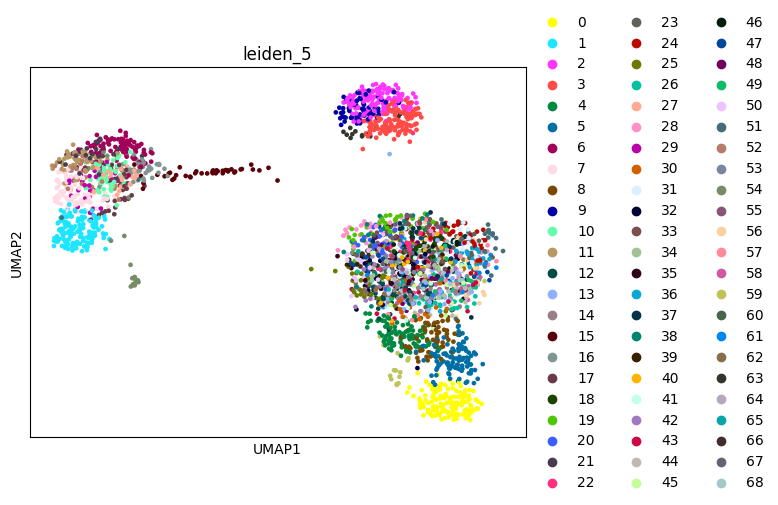

In [36]:
sc.pl.umap(pbmc3k, color='leiden_5')

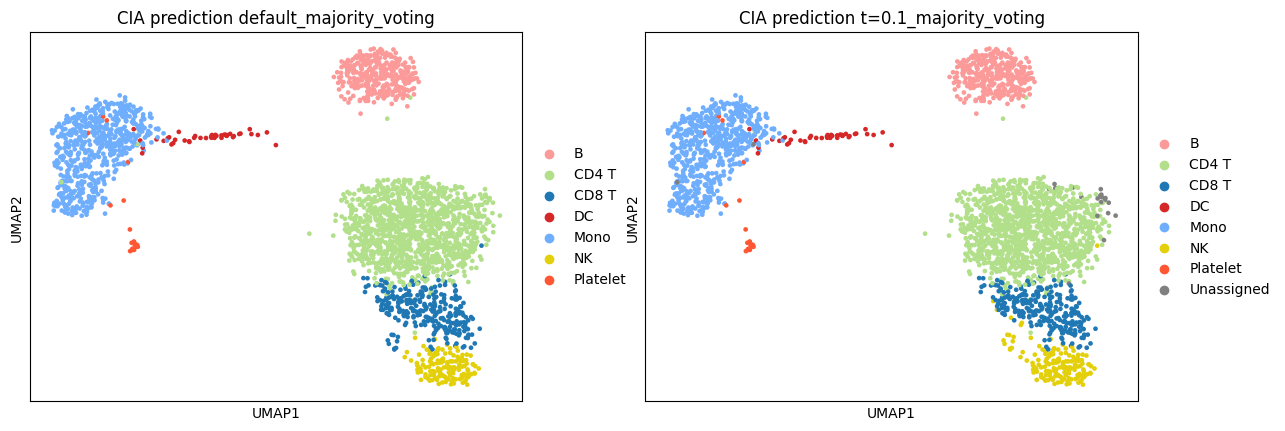

In [37]:

colnames_mv=[c+'_majority_voting' for c in colnames]
pbmc3k.uns['CIA prediction default_majority_voting_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', 
                                                             '#6fadfd', '#E4D00A','#FF5733']
pbmc3k.uns['CIA prediction t=0.1_majority_voting_colors']=['#fb9a99', '#b2df8a', '#1f78b4', '#d62728', 
                                                           '#6fadfd', '#E4D00A','#FF5733','#808080']
sc.pl.umap(pbmc3k, color=colnames_mv)

In [38]:
report.compute_classification_metrics(pbmc3k, classification_obs=colnames_mv,
                              unassigned_label='Unassigned', ref_obs='Cell type')

,SE,SP,PR,ACC,F1,%UN
CIA prediction default_majority_voting,0.967779,0.994630,0.967779,0.990794,0.967779,0.0
CIA prediction t=0.1_majority_voting,0.967138,0.994523,0.967138,0.990611,0.967138,0.8


### Extraction of signatures from Differentially Expressed Genes

If you have a dataset from which **you want to extract signatures** for use with CIA to classify other datasets, **you can use the** `filter_degs` function. This function filters differentially expressed genes (DEGs) obtained with `scanpy.tl.rank_genes_groups` based on specified thresholds. For instance, in the example provided, the thresholds include a log2 fold change greater than 1, a minimum average expression level of 0.2, a z-score above 5, and expression in at least 30% of the cells within each cluster.

In [39]:
sc.tl.rank_genes_groups(pbmc3k, groupby='louvain')
gmt=utils.filter_degs(pbmc3k, groupby='louvain', uns_key='rank_genes_groups', logFC=1,  scores=5, perc=30,
                mean=0.20, direction='up')
for i in gmt.keys():
    print(i + ' signature has '+ str(len(gmt[i])) +' genes')

CD4 T cells signature has 68 genes
CD14+ Monocytes signature has 228 genes
B cells signature has 45 genes
CD8 T cells signature has 40 genes
NK cells signature has 125 genes
FCGR3A+ Monocytes signature has 392 genes
Dendritic cells signature has 100 genes
Megakaryocytes signature has 47 genes


Using the `save_gmt` function, you can convert a dictionary of signatures into a gmt file that is correctly formatted for the `score_all_signatures` and `CIA_classify` functions.

In [40]:
utils.save_gmt(gmt, 'data/pbmc3k_sig.gmt')

### Alternative representation of cell group composition

Alternatively to the canonical confusion matrix, it is possible to visualize classification results using `plot_group_composition`. This function shows the composition of each reference group given the newly performed classification, allowing the use of the same colors used for the corresponding UMAP plot.

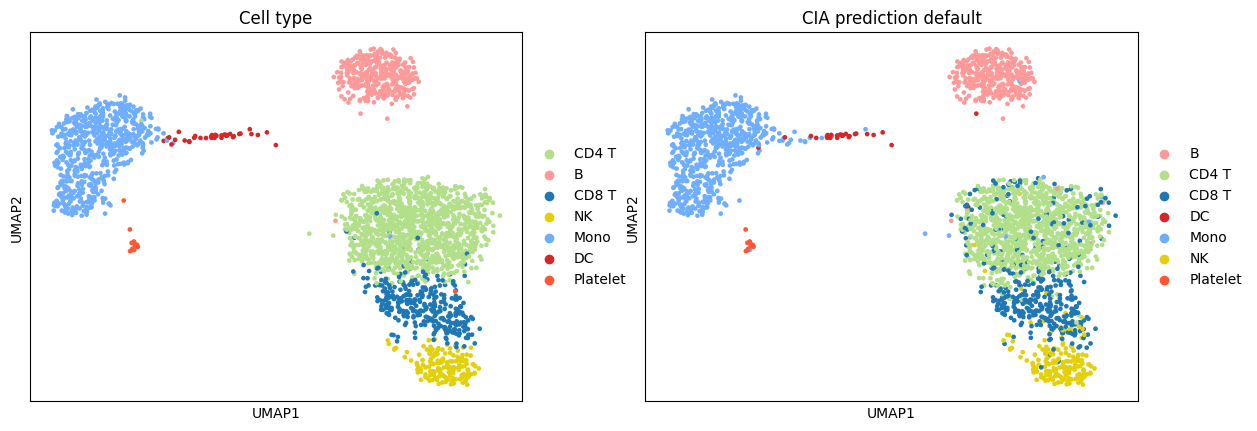

In [41]:
sc.pl.umap(pbmc3k, color= ['Cell type', 'CIA prediction default'])

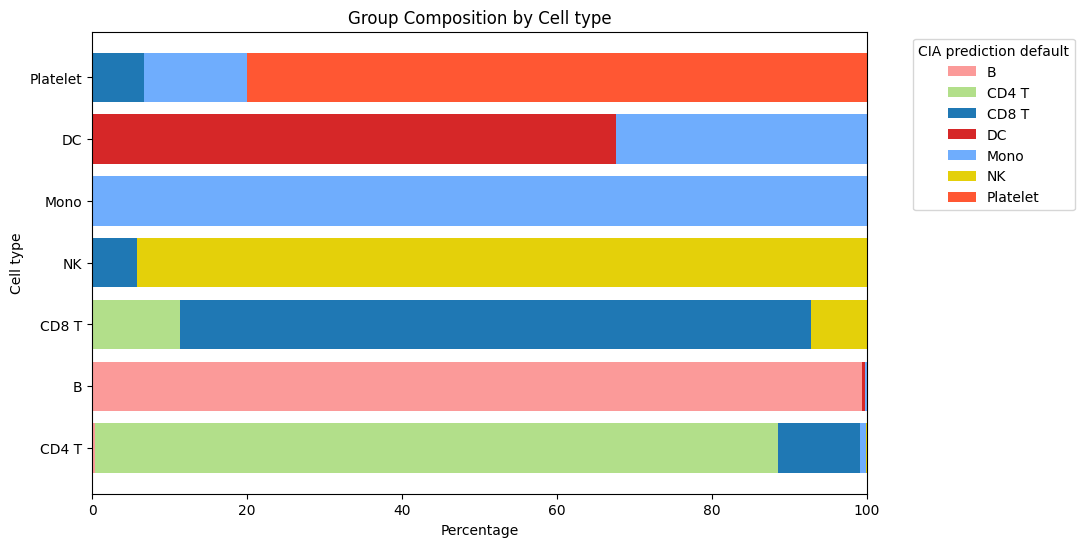

In [42]:
report.plot_group_composition(pbmc3k.obs, comp_col='CIA prediction default', ref_col='Cell type', show_legend=True,
                              palette=pbmc3k.uns['CIA prediction default_colors'])


## Conclusion

In this notebook, we have showed the robustness and versatility of the **Cluster Independent Annotation (CIA)** method. Through the computation of signature scores and subsequent cell classification, **CIA provides a fast and efficient approach to cell type annotation in single-cell RNA sequencing data**. Additionally, we have shown that by increasing the similarity threshold, CIA can effectively mitigate misclassifications, illuminating the presence of ambiguous or novel cell types.

## References

1. Hao, Y., et al. (2021). Integrated analysis of multimodal single-cell data. *Cell*, 184(13), 3573-3587.e29. [https://www.sciencedirect.com/science/article/pii/S0092867421005833](https://www.sciencedirect.com/science/article/pii/S0092867421005833)


2. Satija, R., Farrell, J. A., Gennert, D., Schier, A. F., & Regev, A. (2015). Spatial reconstruction of single-cell gene expression data. *Nature Biotechnology*, 33, 495â€“502. [https://www.nature.com/articles/nbt.3192](https://www.nature.com/articles/nbt.3192)


3. Della Chiara, G., et al. (2021). Gene signature extraction and cell identity recognition at the single-cell level with Cell ID. *Nature Communications*, 12, 2262. [https://www.nature.com/articles/s41467-021-22544-y](https://www.nature.com/articles/s41467-021-22544-y)


4. Celltypist Classifier. (2022). Cell type annotation for single-cell RNA-seq data with CellTypist. *Science*, 374, eabj8222. [https://www.science.org/doi/10.1126/science.abl5197](https://www.science.org/doi/10.1126/science.abl5197)

